# CS146 LBA - Armin Hamp
#### *November 10, 2019*

# Preprocessing

In [1]:
import pystan
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats as sts
import matplotlib.gridspec as gridspec
import math

In [2]:
data= pd.read_csv('cs146_lba.csv')

In [3]:
#create and populate arrays for prices, neighborhood, store and products
prices,neighborhood,store=[],[],[]
r,c=data.shape[0],data.shape[1] # rows and columns
pc=int((c-2)/2) #product columns
product=[[i,i,i] for i in range(1,11)]*r
product=[y for x in product for y in x] #flatten list

for i in range(r):
    quantity=0
    for j in range(2,c):
        if j%2==0:
            quantity=data.iloc[i,j]
        else:
            prices.append(data.iloc[i,j]/quantity) #normalise prices
    store.extend([data.iloc[i,0]]*pc)
    neighborhood.extend([data.iloc[i,1]]*pc)

ind=[] #ind for nan data
for k,price in enumerate(prices):
    if math.isnan(price): ind.append(k)
ind.sort(reverse=True)
for l in ind: #delete nans
    del prices[l]
    del neighborhood[l]
    del store[l]
    del product[l]

print([len(x) for x in [prices,neighborhood,store,product]]) #check if dimensions match up       

[1478, 1478, 1478, 1478]


In [4]:
#transform categorical variables to int format for stan
names_n=set(neighborhood)
dict_n={i : j for i,j in zip(names_n,range(1,len(names_n)+1))}
neighborhood=[dict_n[i] for i in neighborhood]

names_s=set(store)
dict_s={i : j for i,j in zip(names_s,range(1,len(store)+1))}
store=[dict_s[i] for i in store]

#declare dict for produce (for later use)
dict_pr={"Apple":1,"Banana":2,"Tomato":3,"Potato":4,"Flour":5,
    "Rice":6,"Milk":7,"Butter":8,"Egg":9,"Chicken":10}

# Model

The central assumption of this model is that observed prices of items in the store are a function of the product of a base price and multipliers relating to geographical location and brand name of the store where the item was sold.

As base price is defined to be a scale parameter, taking positive real values, I decided to use a Cauchy prior for positive values. I chose this distribution due to its fat tails, which I found appropriate for the uncertainty about the scale of prices. The choices of my parameter values were based on testing the Cauchy PDF until I found a setting in which it looked good.

I chose the log-normal distribution to model the multipliers, as they are postive real numbers and the log-normal distribution accounts for multiplicative effects. I also played around with plotting its PDF and chose the parameter values, such that it centers around 1 with a reasonable scale.

As the assignment description mentioned that the modeling of a price should include some random variation, I chose the likelihood to be a Normal distribution of the product of base price and multipliers with an error term $\sigma$. This $\sigma$ I modelled with an Inverse-Gamma, which I chose as it is commonly used as a prior for error terms.

Below is an illustration of the priors to my stan model.

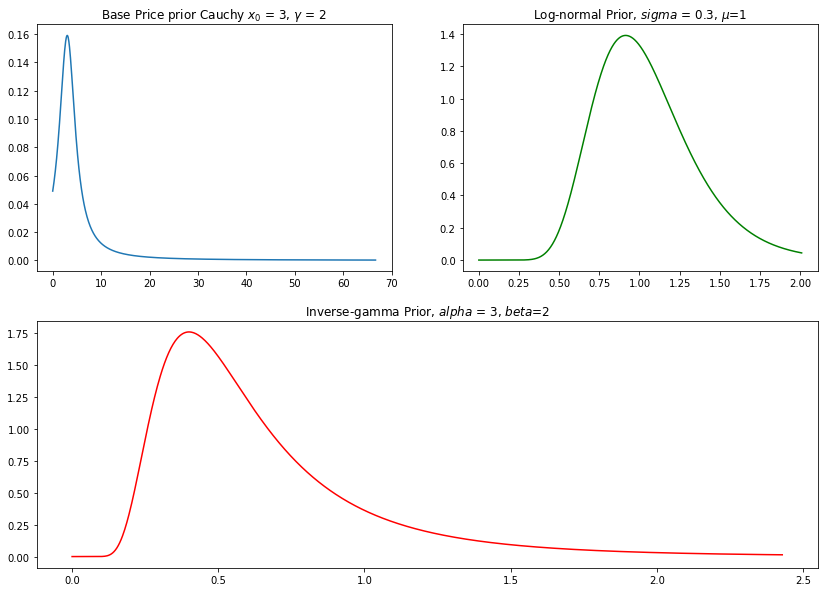

In [5]:
#plot priors
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(14,10))

#base price prior
base_price_prior = sts.cauchy(3, 2)
x = np.linspace(0,base_price_prior.ppf(0.99), 1000)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(x, base_price_prior.pdf(x))
ax1.title.set_text("Base Price prior Cauchy $x_0$ = 3, $\gamma$ = 2")


# multiplier prior
error_prior = sts.lognorm(s=0.3,scale=1)
x = np.linspace(0,error_prior.ppf(0.99), 1000)
ax2 = fig.add_subplot(gs[0, 1]) # row 0, col 1
ax2.plot(x, error_prior.pdf(x),'g')
ax2.title.set_text("Log-normal Prior, $sigma$ = 0.3, $\mu$=1")


# error term prior
error_prior = sts.invgamma(a=4, scale=2)
x = np.linspace(0,error_prior.ppf(0.99), 1000)
ax3 = fig.add_subplot(gs[1, :]) # row 1, span all columns
ax3.plot(x, error_prior.pdf(x),'r')
ax3.title.set_text("Inverse-gamma Prior, $alpha$ = 3, $beta$=2")
plt.show()

# Stan Model

In [6]:
stan_code ='''
data {
    //variables to specify array lengths
    int<lower=0> n_data; 
    int<lower=0> n_product;
    int<lower=0> n_store;
    int<lower=0> n_neighbourhood;
    
    //preprocessed data arrays
    real<lower=0> price[n_data];
    int<lower=1> product[n_data];
    int<lower=1> store[n_data];
    int<lower=1> neighbourhood[n_data];
}

parameters{
    //the parameters stan will create posterior samples for
    real<lower=0> base_price[n_product]; 
    real<lower=0> store_multiplier[n_store];
    real<lower=0> location_multiplier[n_neighbourhood];
    real<lower=0> sigma;
}

model {
    // Priors
    base_price ~ cauchy(3,2);
    store_multiplier ~ lognormal(0.3,1);
    location_multiplier ~lognormal(0.3,1);
    sigma ~ inv_gamma(4,2);
    
    // Likelihood
    for (i in 1:n_data){
        price[i] ~ normal(base_price[product[i]]*\
        store_multiplier[store[i]]*\
        location_multiplier[neighbourhood[i]], sigma);
    }
    
}

'''
model=pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f69989cd08c21750dafc52ca1597ab3d NOW.
C:\Users\Armin\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Armin\AppData\Local\Temp\tmpu_299vk7\stanfit4anon_model_f69989cd08c21750dafc52ca1597ab3d_666831485422757662.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [7]:
stan_data = {
    "n_data": len(prices),
    "n_product": len(dict_pr),
    "n_store": len(dict_s),
    "n_neighbourhood": len(dict_n),
    "price": prices,
    "product": product,
    "store": store,
    "neighbourhood": neighborhood
}

In [8]:
results = model.sampling(data=stan_data)
print(results)

C:\Users\Armin\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_f69989cd08c21750dafc52ca1597ab3d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
base_price[0]             3.1    0.03   0.98   1.58   2.39   2.97   3.68   5.37    843    1.0
base_price[1]            2.26    0.02   0.75   1.13   1.72   2.15   2.69   4.03    890    1.0
base_price[2]            5.97    0.07   1.87   3.08   4.62    5.7   7.07  10.34    797    1.0
base_price[3]            1.73    0.02   0.59   0.83    1.3   1.64   2.07   3.09    902   1.01
base_price[4]            1.68    0.02   0.59   0.78   1.26   1.59   2.02   3.03    937    1.0
base_price[5]            5.31    0.06   1.67   2.74   4.09   5.06   6.32   9.17    811    1.0
base_price[6]            1.67    0.02   0.58   0.79   1.25   1.59   2.01   3.02    907    1.0
base_price[7]           10.09    0.11   3.15   5.21    7.8 

# What is the basic average price for each product?

Below, I plotted the posterior samples for the base price of each product and took the mean of the samples and displayed in a table.

These posteriors should be interpreted as the base price that gets multiplied by the store and location multiplier to give us the actual price of the product.

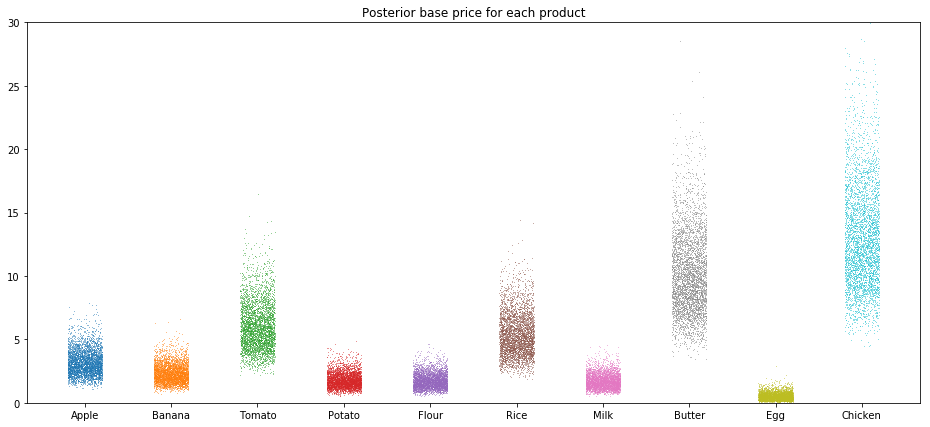

In [9]:
#extract samples
samples=results.extract()

#plot posterior dist for each product
plt.figure(figsize=(16,7))
for i in range(len(dict_pr)):
    plt.plot(sts.uniform.rvs(loc=i+1-0.2, scale=0.4, size=4000), samples['base_price'][:,i], ',', alpha=0.5)
plt.title('Posterior base price for each product')
plt.xticks(list(range(1,11)), list(dict_pr.keys()))
plt.ylim(0, 30)
plt.show()

In [10]:
#calculate posterior sample means
base_prices=samples["base_price"]   
mean_prices=np.mean(base_prices,axis=0)
price_table=pd.DataFrame({
    "Product Name": list(dict_pr.keys()),
    "Mean Base Price": mean_prices
}
)
price_table.style.background_gradient(cmap="RdYlGn")
display(price_table)

Product Name  Mean Base Price
0        Apple         3.104113
1       Banana         2.260974
2       Tomato         5.974792
3       Potato         1.725690
4        Flour         1.678512
5         Rice         5.309886
6         Milk         1.666647
7       Butter        10.086620
8          Egg         0.463369
9      Chicken        13.001367

# How much does each of the following factors modify the basic price of the product (up or down)? 

Below, I plotted the posterior samples for the store and location multipliers and took the mean of those samples and displayed them in tables.

We can observe LIDL to be the cheapest and the EDEKA to be the most expensive store to shop at. Kreuzberg is the cheapest and Schöneberg is the most expensive location. 

Also, it should be noted that originally store multipliers are $<1$, whereas location multipliers $>1$. This means that stores bring down, and locations scale up the base price of products. I believe that a better model would have multipliers that are distributed around 1, so that our posteriors can be interpreted that "there are stores/locations, which bring base prices up and there are other stores/locations, which bring base prices down". That would make the interpretation of the posterior more intuitive. 

After many trials I found the appropriate prior hyperparameters to achieve these results. See results below.

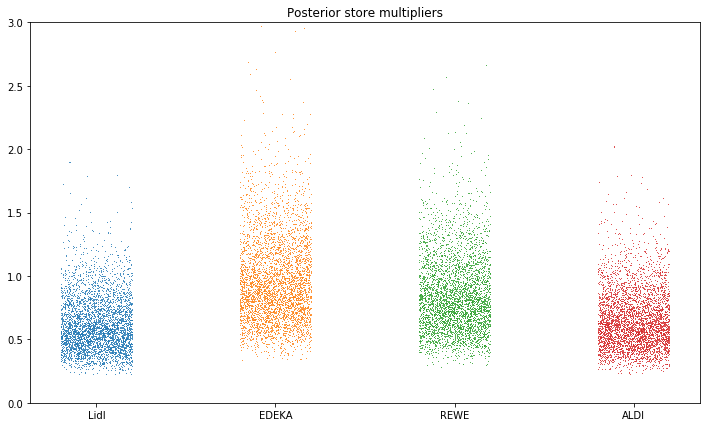

In [11]:
#plot posterior dist for store multiplier
plt.figure(figsize=(12,7))
for i in range(len(dict_s)):
    plt.plot(sts.uniform.rvs(loc=i+1-0.2, scale=0.4, size=4000), samples['store_multiplier'][:,i], ',', alpha=0.8)
plt.title('Posterior store multipliers')
plt.xticks(list(range(1,len(dict_s)+1)), list(dict_s.keys()))
plt.ylim(0, 3)
plt.show()

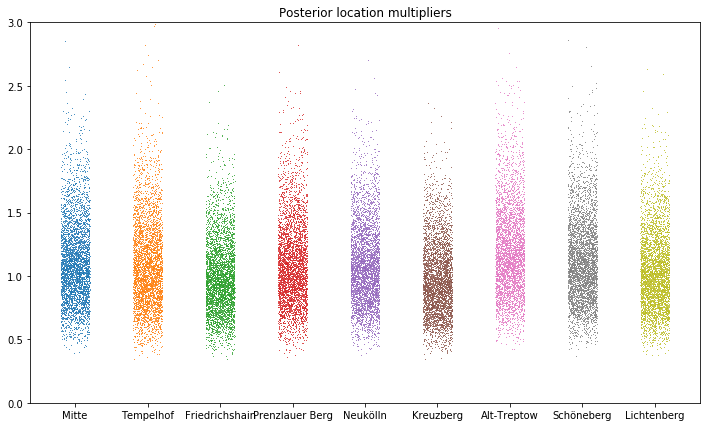

In [12]:
#plot posterior dist for store multiplier
plt.figure(figsize=(12,7))
for i in range(len(dict_n)):
    plt.plot(sts.uniform.rvs(loc=i+1-0.2, scale=0.4, size=4000), samples['location_multiplier'][:,i], ',', alpha=0.8)
plt.title('Posterior location multipliers')
plt.xticks(list(range(1,len(dict_n)+1)), list(dict_n.keys()))
plt.ylim(0, 3)
plt.show()

In [13]:
#table for store mutlipliers
store_mpl=samples["store_multiplier"]   
mean_store=np.mean(store_mpl,axis=0)
price_table=pd.DataFrame({
    "Store Name": list(dict_s.keys()),
    "Mean Multiplier Value": mean_store
}
)
#table for store mutlipliers
loc_mpl=samples["location_multiplier"]   
mean_loc=np.mean(loc_mpl,axis=0)
loc_table=pd.DataFrame({
    "Area Name": list(dict_n.keys()),
    "Mean Multiplier Value": mean_loc
}
)
display(price_table,loc_table)


Store Name  Mean Multiplier Value
0       Lidl               0.612768
1      EDEKA               0.958976
2       REWE               0.839329
3       ALDI               0.645274

Area Name  Mean Multiplier Value
0            Mitte               1.108172
1        Tempelhof               1.090957
2   Friedrichshain               0.985477
3  Prenzlauer Berg               1.087879
4         Neukölln               1.083155
5        Kreuzberg               0.972189
6      Alt-Treptow               1.197220
7       Schöneberg               1.120031
8      Lichtenberg               1.033133

#  Does price variation by geographical location correlate with variation in rental prices?
Data source: https://www.berlinhyp.de/bhyp/en/medias/sys_master/pdf/h68/hd1/8812673892382.pdf
The data is from 2018. Where "smaller" district was not identified, I used values for encompassing district.

In [14]:
#median EUR/m^2/month
rental_price=[6.2,7.015,6.62,6.79,6.79,7,6.46,6.66,7.03]
corr=sts.pearsonr(rental_price,mean_loc) #pearson's r

print("Pearson's r for the correlation between mean location multiplier with median rental price", round(corr[0],3))
print("The p-value of this correlation is",round(corr[1],3))

Pearson's r for the correlation between mean location multiplier with median rental price -0.504
The p-value of this correlation is 0.167


As the p-value of the correlation indicates, we have a non-significant weak negative correlation between rental prices and the posterior price multiplier for geographical region.

However, these results should not be taken as conclusive to the correlation of these two measures. It may be a result of to little data collected on our side, and insufficient or perhaps inaccurate measures for rental prices.

# HC Applications
**#variables**: Both in my written explanation and annotated code I accurately identify variables and implement well working models that correctly capture the model description outlined in the instructions.

**#designthinking**: During the writing of this assignment, my Jupyter notebook ran into an error and my progress was not saved on two occasions. I had to re-write from scratch the Preprocessing section. With each iteration, I was able to think of more efficient ways of processing the data shrink down my code, such that it does in 28 lines what it used to in 100. It was a really great "accidental" excercise and it allowed me to implement iterative improvements to my design.

# Appendix

Locations visited:
1. Wrangelstraße 53, 10997 Berlin at 11/1/2019 17:30
2. Kiefholzstraße 50, 12435 Berlin at 11/1/2019 18:15

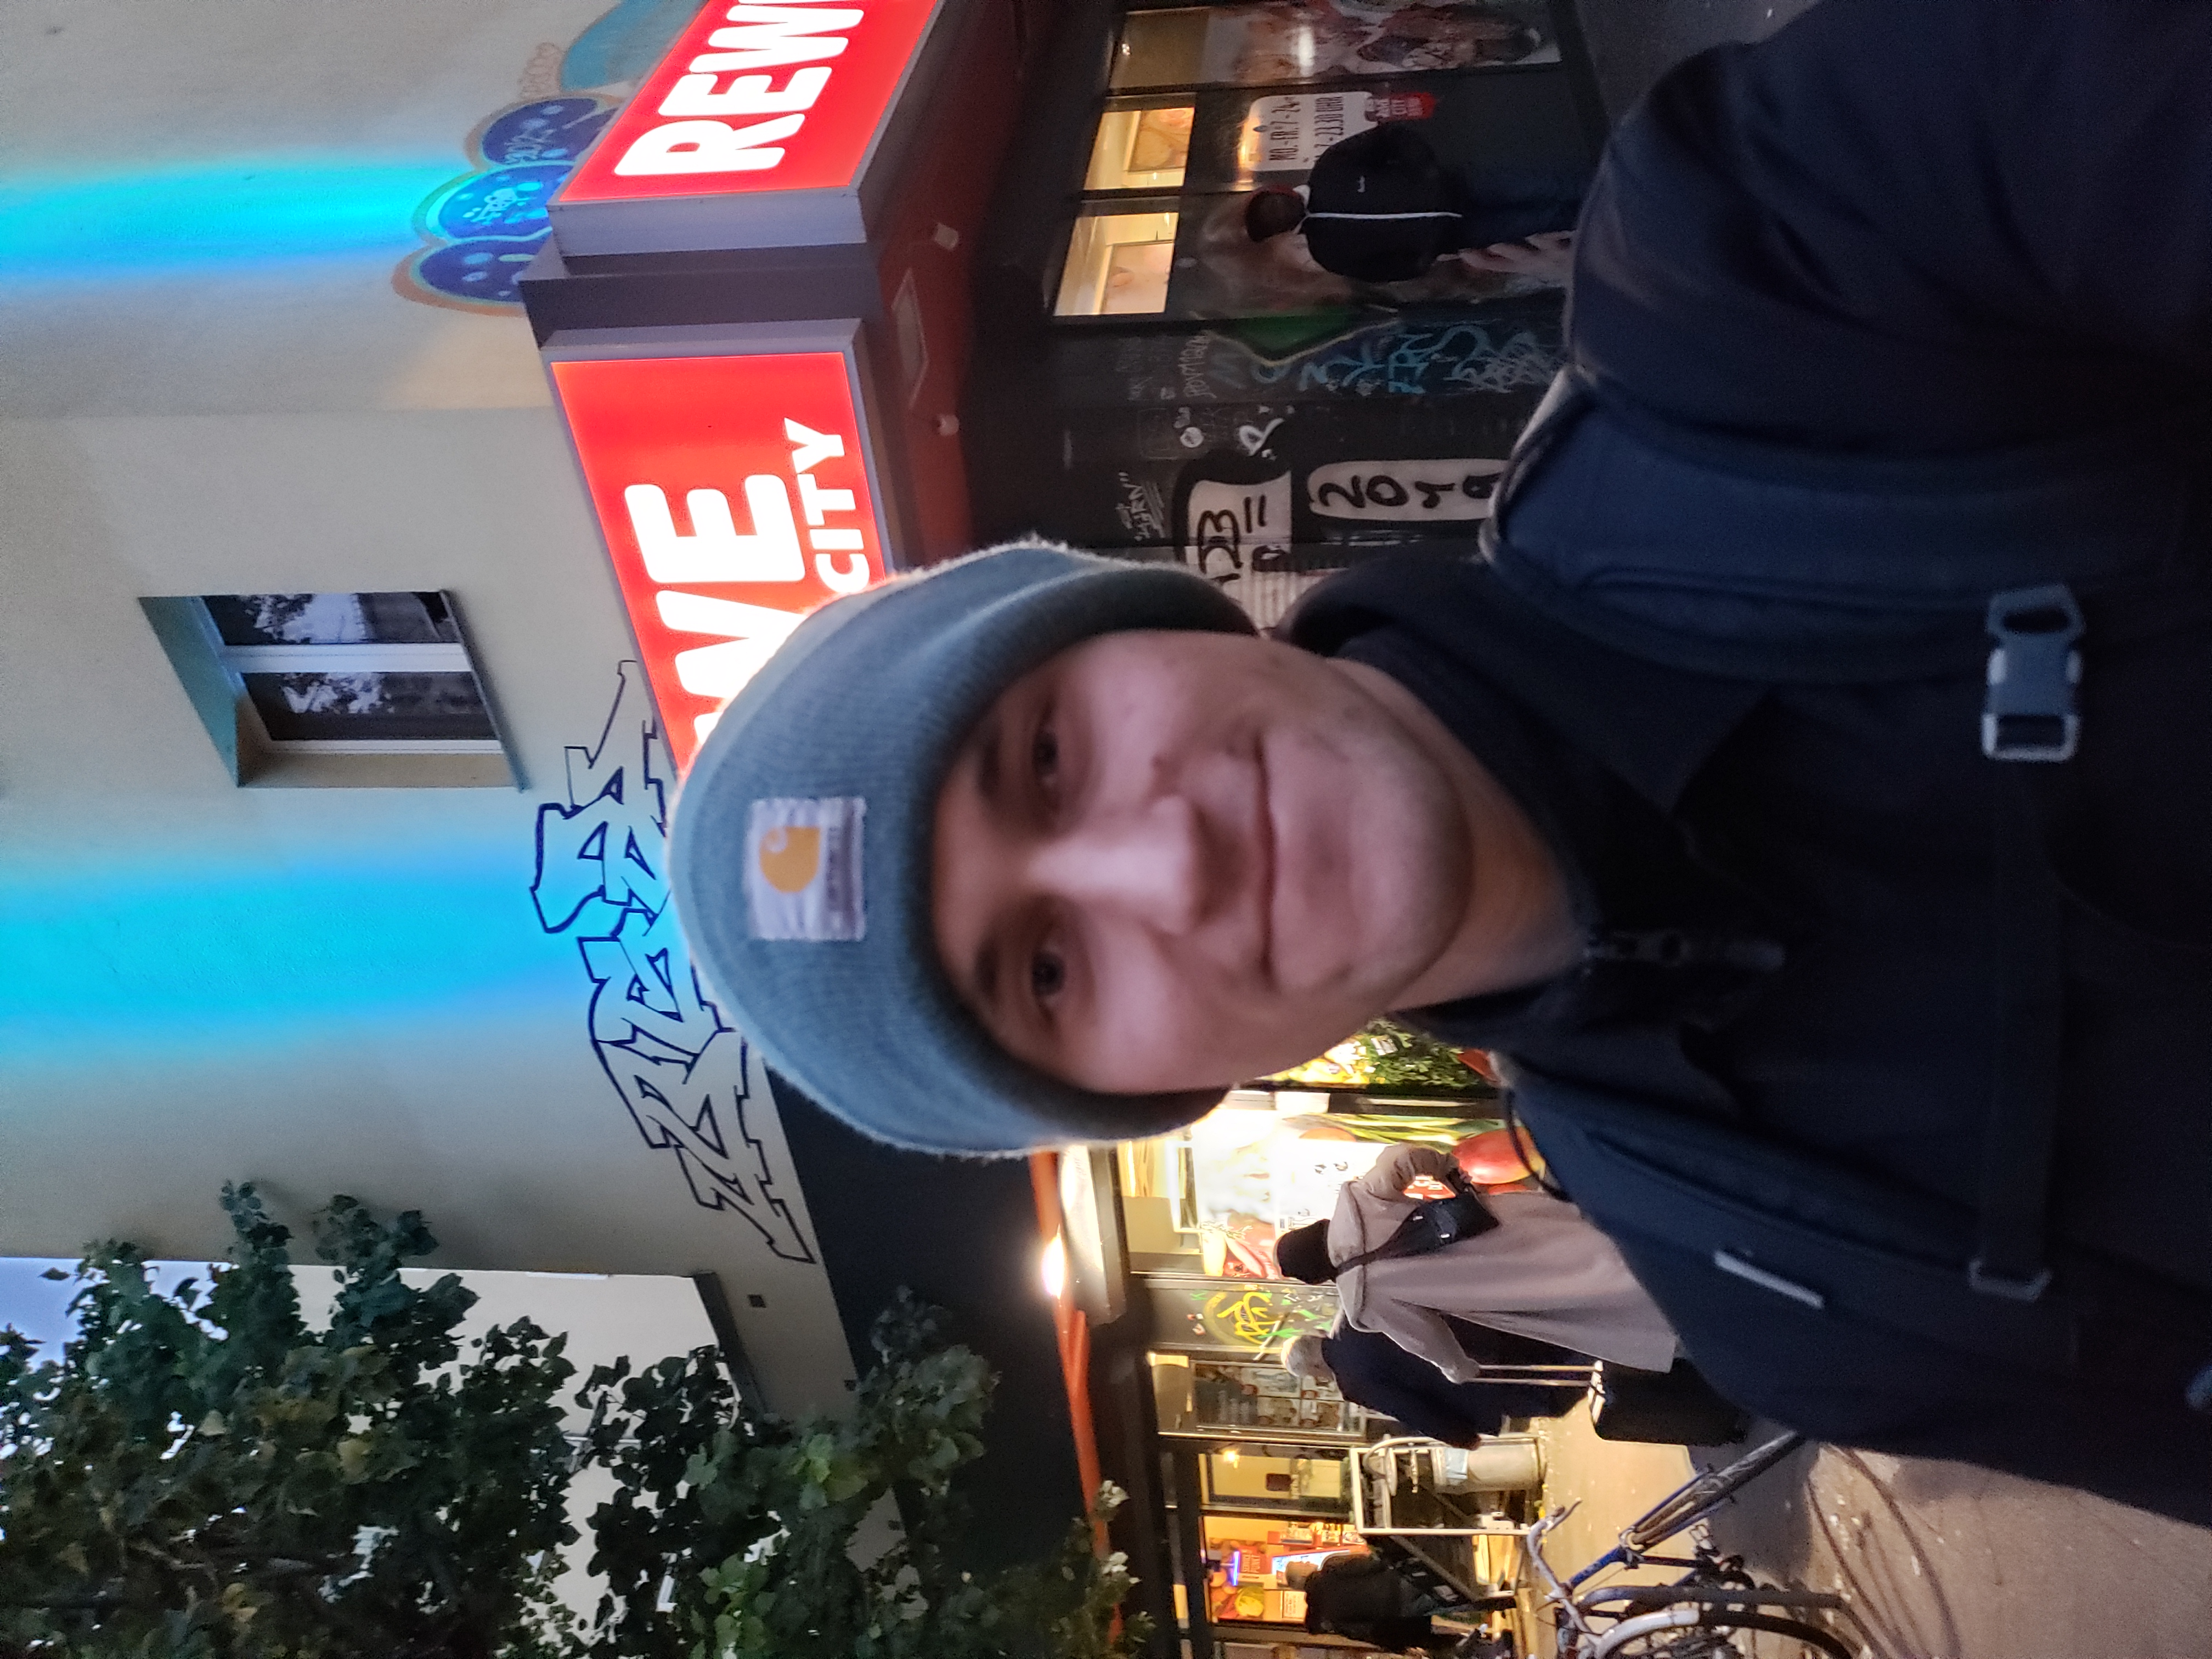

In [15]:
#unfortunately I only took a photo at Wrangelstrasse
from IPython.display import Image
Image("arminatrewe.jpg")